In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from scipy.special import logit

In [2]:
pix2 = val_pix[0]
pix2

9

In [3]:
cat = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8_no_fn.csv')
cat = cat[cat['status'] == 'tp']
cat = cat[cat['catalog'] == 'planck_z']
cat = cat[radec2pix(cat['tRA'], cat['tDEC'], 2) == pix2]
cat.index = np.arange(len(cat))
cat.shape

(29, 15)

In [4]:
size = 16

In [5]:
coords = np.stack([cat['tRA'], cat['tDEC']]).T
coords.shape

(29, 2)

In [6]:
matr = one_pixel_fragmentation(2, pix2, 10)

In [7]:
mdict = matr2dict(matr)

In [8]:
pz_model = load_planck_model('/home/rt2122/Models/pz_only_rot/pz_only_rot.ep0028-vl0.005815-l0.004588.hdf5')
act_model = load_planck_model('/home/rt2122/Models/act_found2/pz_act_found2.ep0022-vl0.008890-l0.008042.hdf5')
all_model = load_planck_model('/home/rt2122/Models/all_found/all_found.ep0034-vl0.009741-l0.008339.hdf5')

In [9]:
pz_data_dict = gen_pics_for_detection(pix2, pz_model, step=8)
pz_connected = connect_masks(pz_data_dict['ans'], pz_data_dict['pic_idx'])
del pz_data_dict

In [10]:
act_data_dict = gen_pics_for_detection(pix2, act_model, step=8)
act_connected = connect_masks(act_data_dict['ans'], act_data_dict['pic_idx'])
del act_data_dict

In [ ]:
all_data_dict = gen_pics_for_detection(pix2, all_model, step=4)
all_connected = connect_masks(all_data_dict['ans'], all_data_dict['pic_idx'])
del all_data_dict

In [12]:
pic, mask = draw_pic_with_mask(None, coords, matr=matr)
ypic = draw_pic(matr, y=True)

In [13]:
cm1 = sns.light_palette("red", as_cmap=True)
cm2 = sns.light_palette("gray", as_cmap=True)

In [70]:
def pic8(idx): 
    print(cat.iloc[idx])
    x, y = mdict[radec2pix(*coords[idx], 2**11)]
    sm_pic = pic[x-size:x+size, y-size:y+size]
    sm_ypic = ypic[x-size:x+size, y-size:y+size]
    sm_mask = mask[x-size:x+size, y-size:y+size]
    sm_pz = pz_connected[x-size:x+size, y-size:y+size]
    sm_act = act_connected[x-size:x+size, y-size:y+size]
    sm_all = all_connected[x-size:x+size, y-size:y+size]
    for i in range(6):
        print(sm_pic[:,:,i].min(), sm_pic[:,:,i].max())
    print(sm_all.min())
    val_min=[-1, -1, -1, 0, 2, 3]
    val_max=[1, 0.5, 1, 5, 14, 22]
    s = 100
    _, ax = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.001)
    
    pic_dict = {6 : logit(sm_all), 7 : sm_ypic}
    print(pic_dict[6].min(), pic_dict[6].max())
    print(pic_dict[7].min(), pic_dict[7].max())
    
    for i in range(2):
        for j in range(4):
            if 4*i+j < 6:
                ax[i][j].imshow(sm_pic[:,:,4*i+j])#, vmin=val_min[4*i+j], vmax=val_max[4*i+j])#, cmap=cmg)
                #ax[i][j].imshow(sm_mask[:,:,0], alpha=0.5*sm_mask[:,:,0].astype(float), cmap=cm2)
            else:
                ax[i][j].imshow(pic_dict[4*i+j][:,:,0], vmin=-7 if 4*i+j ==6 else None)#, cmap=cmg)
                #ax[i][j].imshow(sm_mask[:,:,0], alpha=0.5*sm_mask[:,:,0].astype(float), cmap=cm2)
    for i in range(2):
        for j in range(4):
            ax[i][j].scatter([size], [size], marker='x', c='r', s=s)
            
    ax[1][-1].set_xlabel('y map')
    ax[1][-2].set_xlabel('Model 3 (pz_all_found34)')

RA           143.776
DEC         0.797716
area              30
min_rad       2.0899
max_rad      4.65023
mean_rad     3.21802
min_pred    0.140508
max_pred    0.928415
tRA           143.82
tDEC        0.818445
status            tp
catalog     planck_z
M500         5.47738
z           0.356823
pix2         val_pix
Name: 17, dtype: object
-1.9123239517211914 1.4303807020187378
-1.667750358581543 0.7274483442306519
-1.4795191287994385 1.1387231349945068
-0.5674564242362976 5.67755651473999
1.5705593824386597 14.927040100097656
3.409332752227783 23.026948928833008
4.779547186639643e-07
-14.553749361815898 1.8347108261256166
-1.0999698638916016 1.3810291290283203


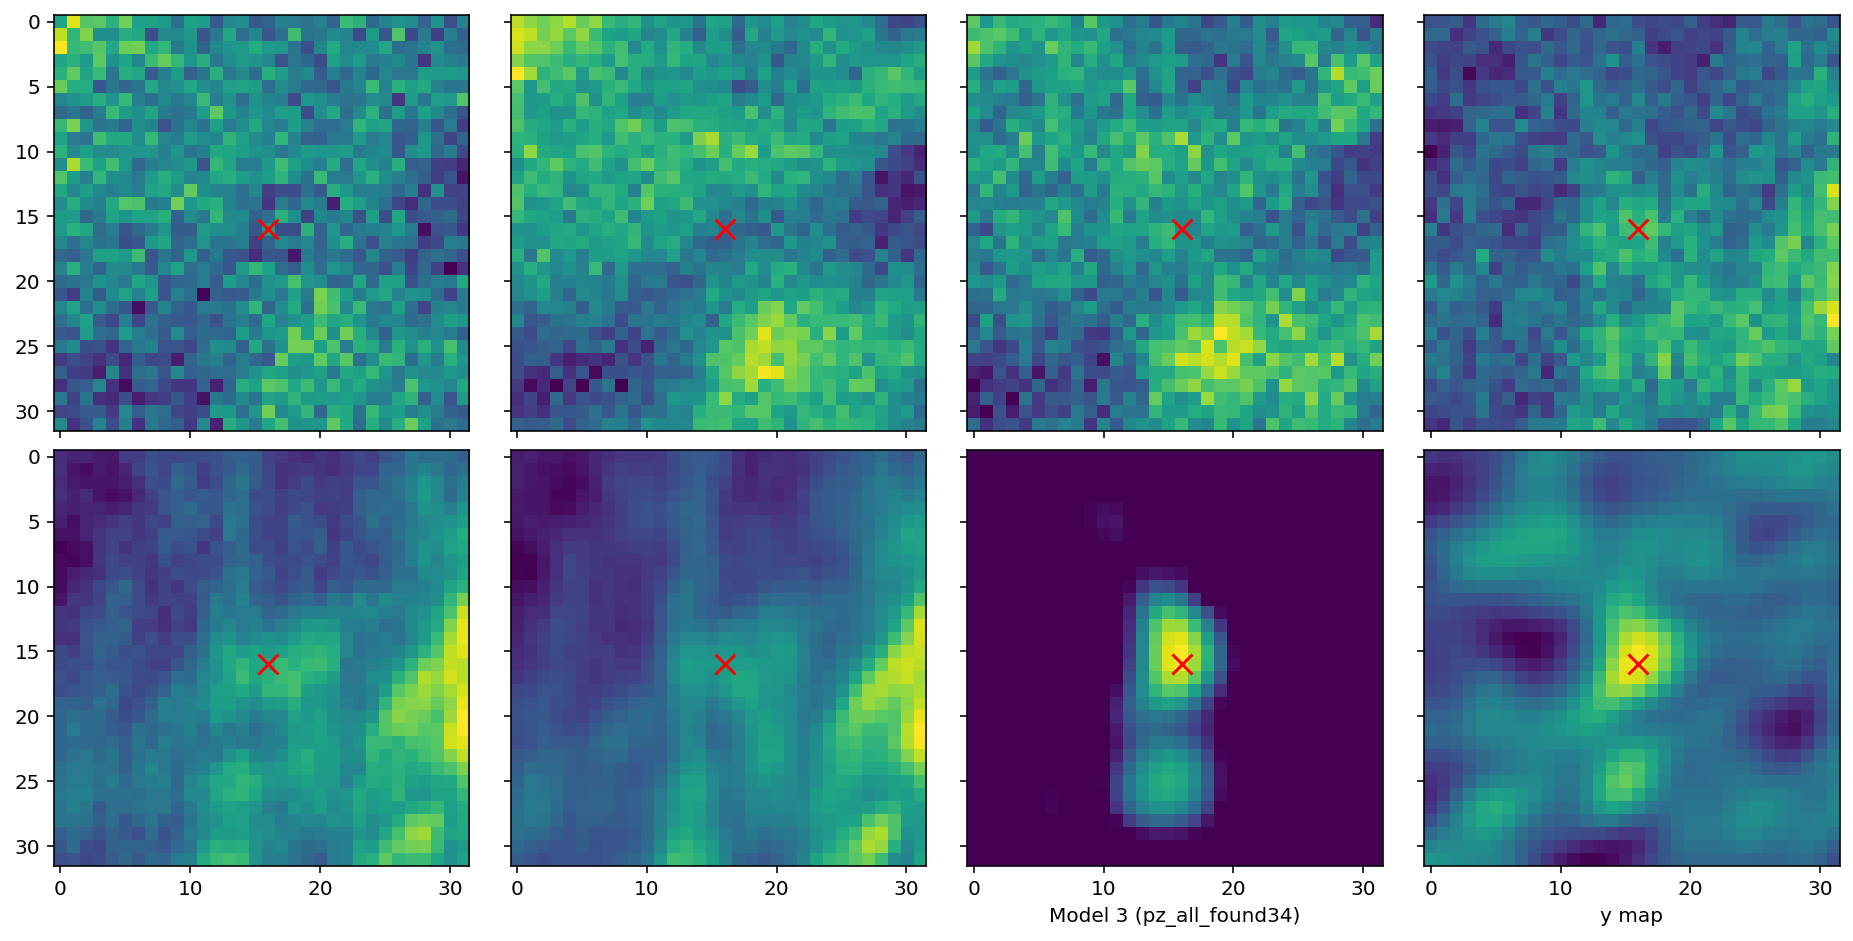

In [71]:
pic8(17)

RA           143.776
DEC         0.797716
area              30
min_rad       2.0899
max_rad      4.65023
mean_rad     3.21802
min_pred    0.140508
max_pred    0.928415
tRA           143.82
tDEC        0.818445
status            tp
catalog     planck_z
M500         5.47738
z           0.356823
pix2         val_pix
Name: 17, dtype: object
-1.9123239517211914 1.4303807020187378
-1.667750358581543 0.7274483442306519
-1.4795191287994385 1.1387231349945068
-0.5674564242362976 5.67755651473999
1.5705593824386597 14.927040100097656
3.409332752227783 23.026948928833008
4.779547186639643e-07
-14.553749361815898 1.8347108261256166
-1.0999698638916016 1.3810291290283203


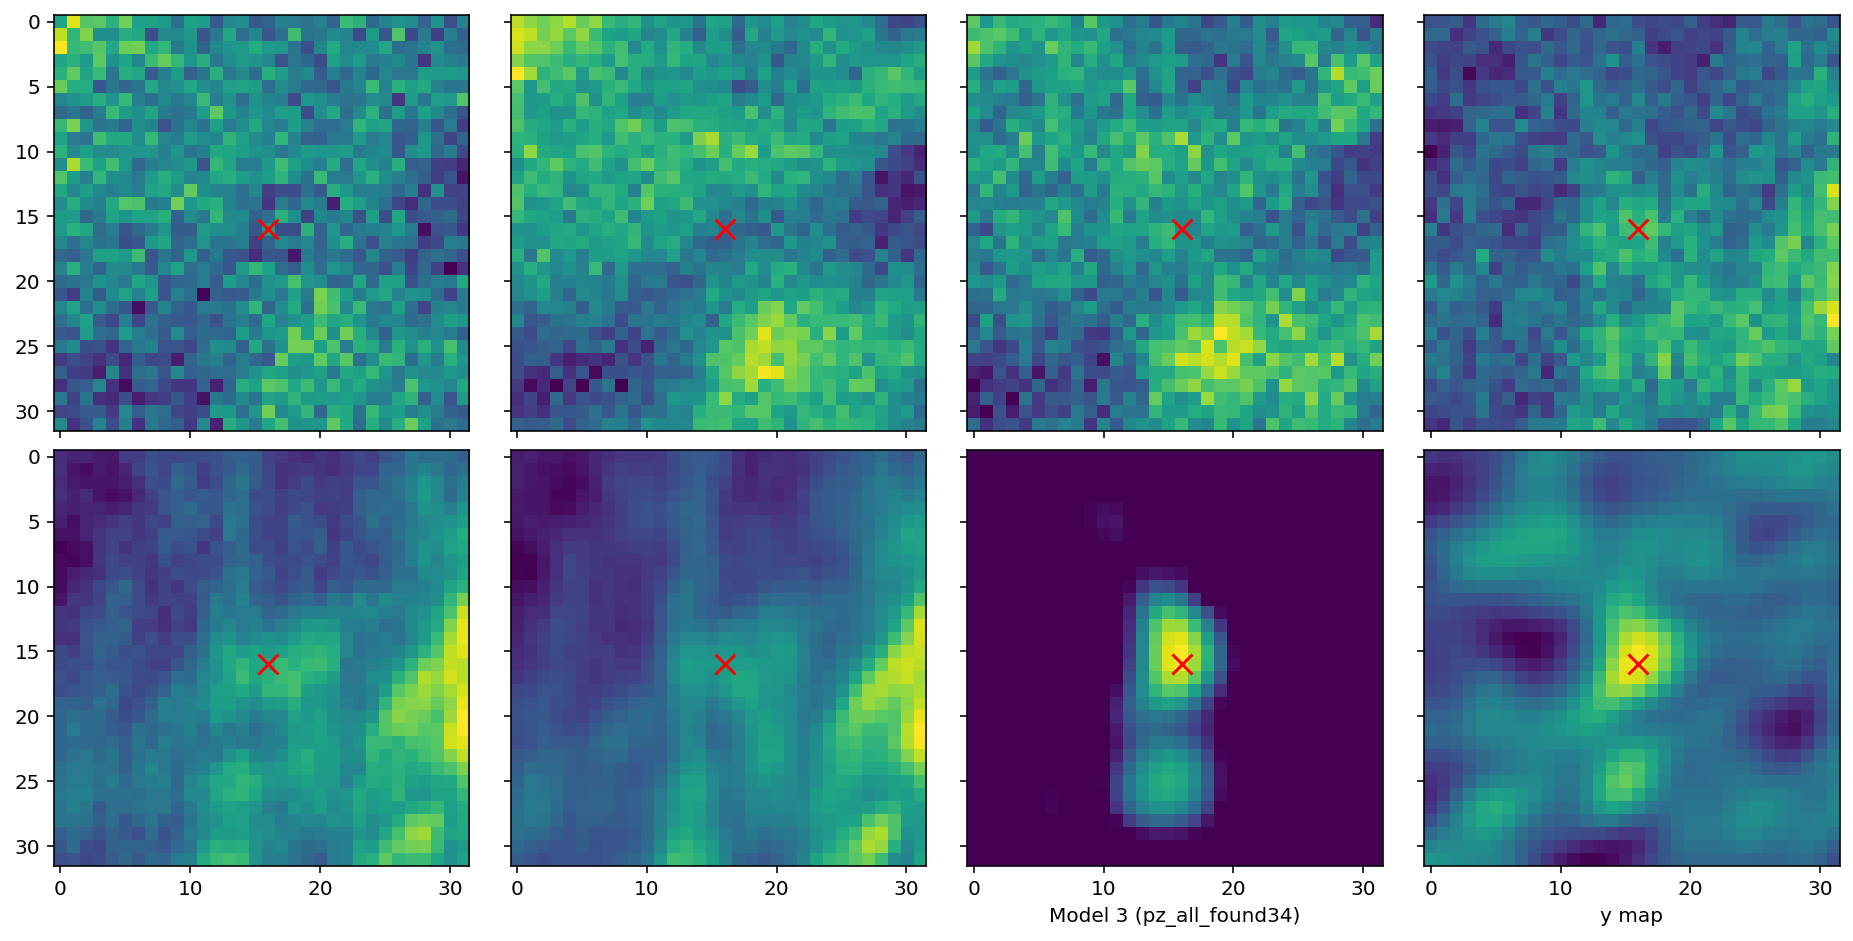

In [72]:
pic8(17)

RA           158.579
DEC         -17.3668
area              26
min_rad      1.53806
max_rad      3.93125
mean_rad     2.92614
min_pred    0.100574
max_pred    0.991847
tRA          158.591
tDEC        -17.3442
status            tp
catalog     planck_z
M500         3.76111
z               0.21
pix2         val_pix
Name: 0, dtype: object
-2.0674774646759033 1.8049649000167847
-1.509275197982788 1.301396369934082
-1.4607629776000977 1.7011680603027344
-0.11113885045051575 5.3661580085754395
3.6636197566986084 10.061280250549316
5.545619010925293 13.645721435546875
3.491831116845627e-07
-14.867669027840845 3.099049813671664
-0.4730857312679291 1.5141361951828003


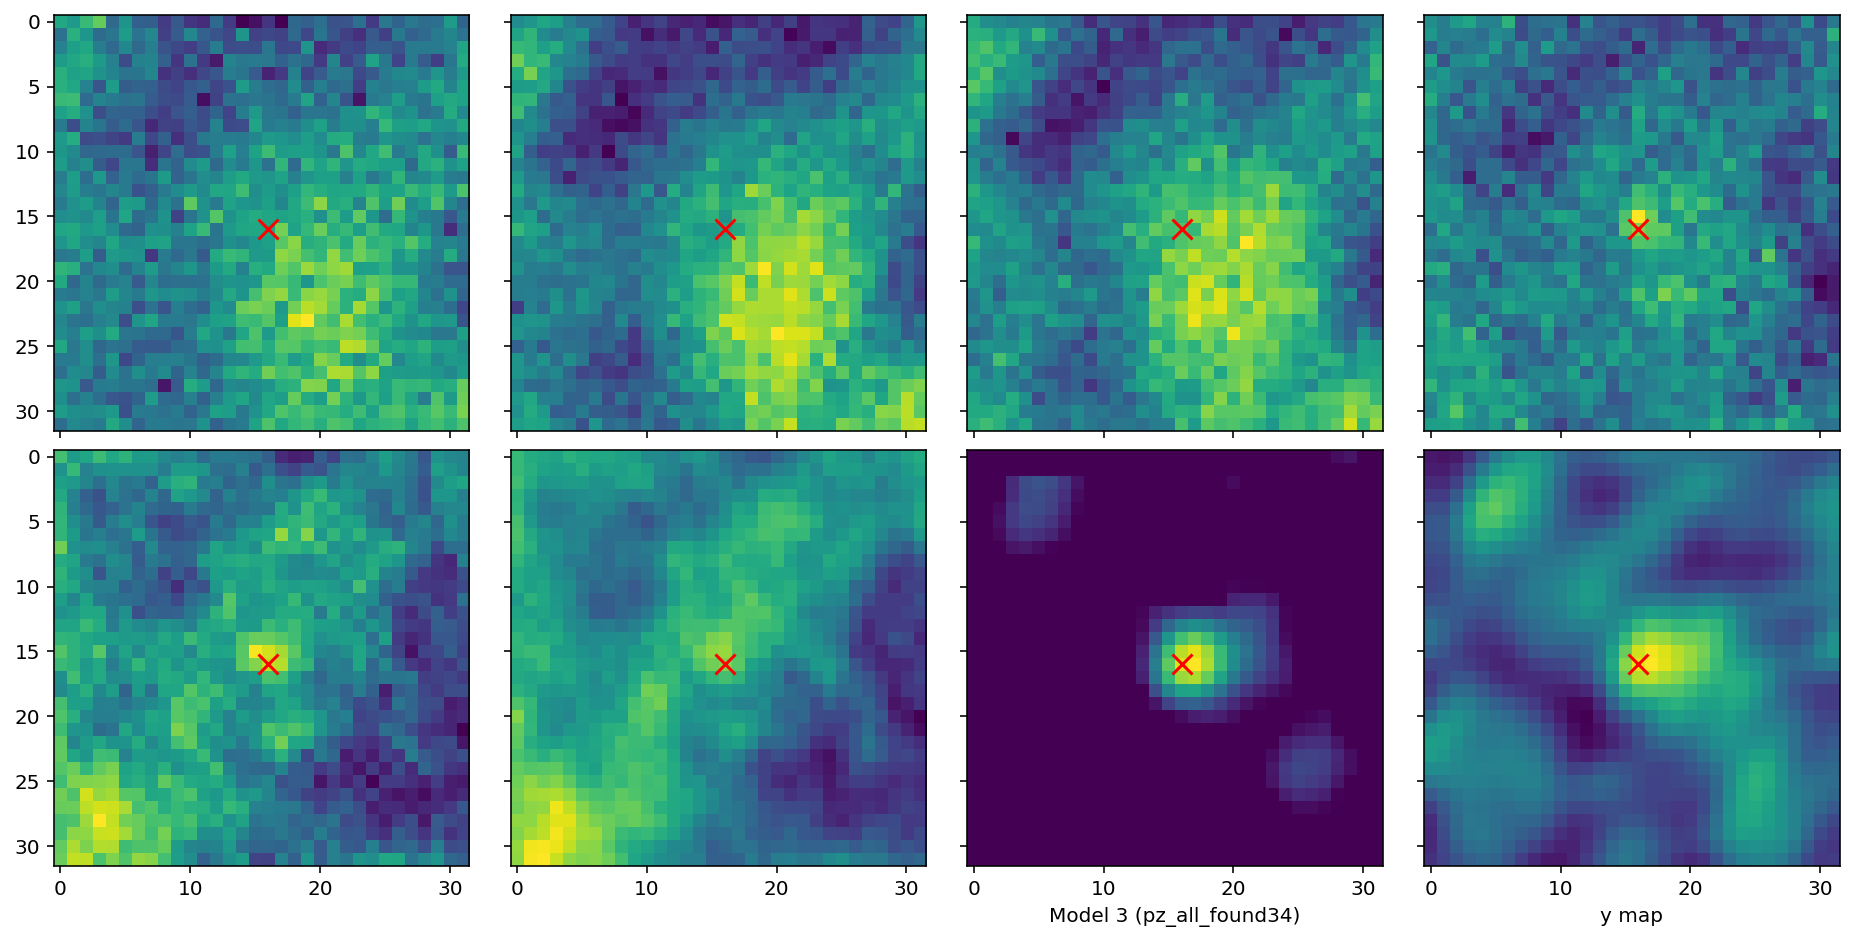

In [73]:
pic8(0)

RA           166.422
DEC         -10.2505
area              24
min_rad      1.33026
max_rad      3.79593
mean_rad     2.85176
min_pred      0.1188
max_pred    0.970661
tRA          166.456
tDEC        -10.2348
status            tp
catalog     planck_z
M500         6.08402
z              0.466
pix2         val_pix
Name: 6, dtype: object
-2.47221302986145 0.8735296130180359
-2.143181324005127 0.48127666115760803
-2.1468398571014404 0.8655064702033997
-1.4830926656723022 3.428926944732666
0.5962614417076111 8.81460952758789
3.3454337120056152 13.219074249267578
1.2140445786179566e-07
-15.9241381171476 2.094379237935831
-0.7731982469558716 1.7502020597457886


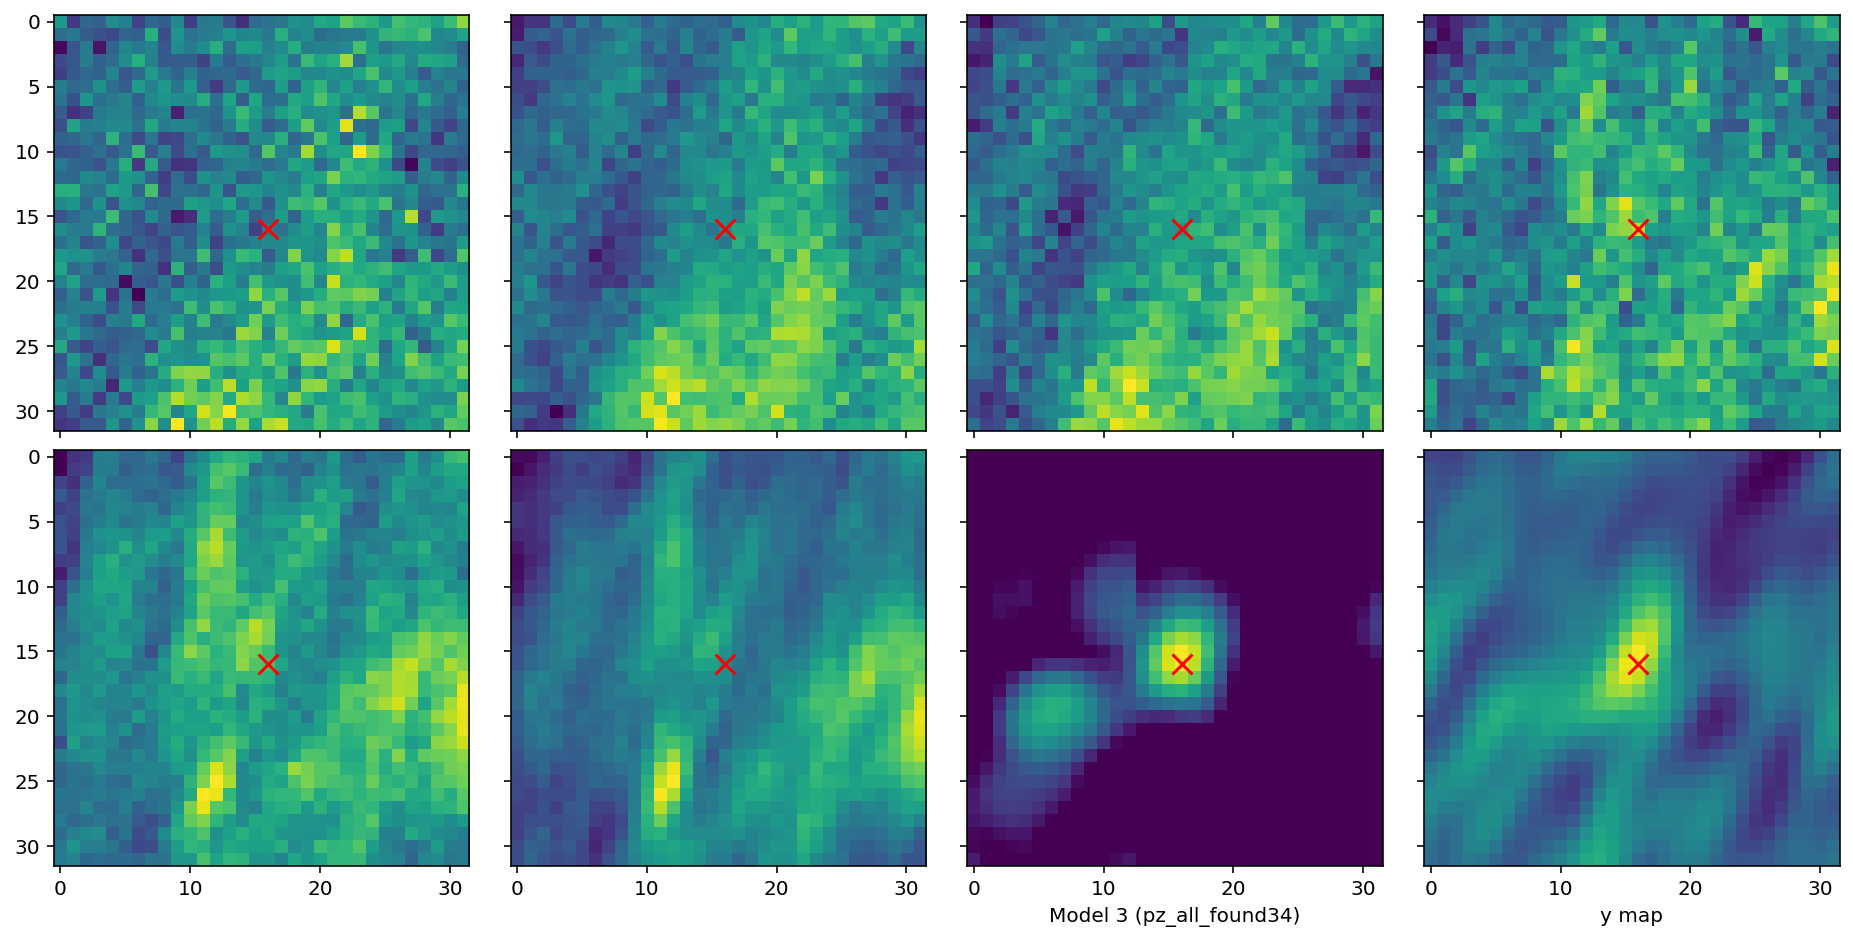

In [74]:
pic8(6)

RA           155.812
DEC         -6.62398
area              37
min_rad      1.33671
max_rad      6.85781
mean_rad     3.74707
min_pred    0.101054
max_pred    0.964823
tRA          155.786
tDEC        -6.60545
status            tp
catalog     planck_z
M500         4.08804
z             0.2544
pix2         val_pix
Name: 14, dtype: object
-2.1056904792785645 1.9578357934951782
-2.076246976852417 1.3504432439804077
-1.9613020420074463 1.622973084449768
-0.9268047213554382 3.364109754562378
1.3682762384414673 6.223700046539307
3.2940969467163086 7.477478504180908
5.074566939156089e-07
-14.493853954400636 1.5969298594842727
-0.7940461039543152 1.47892427444458


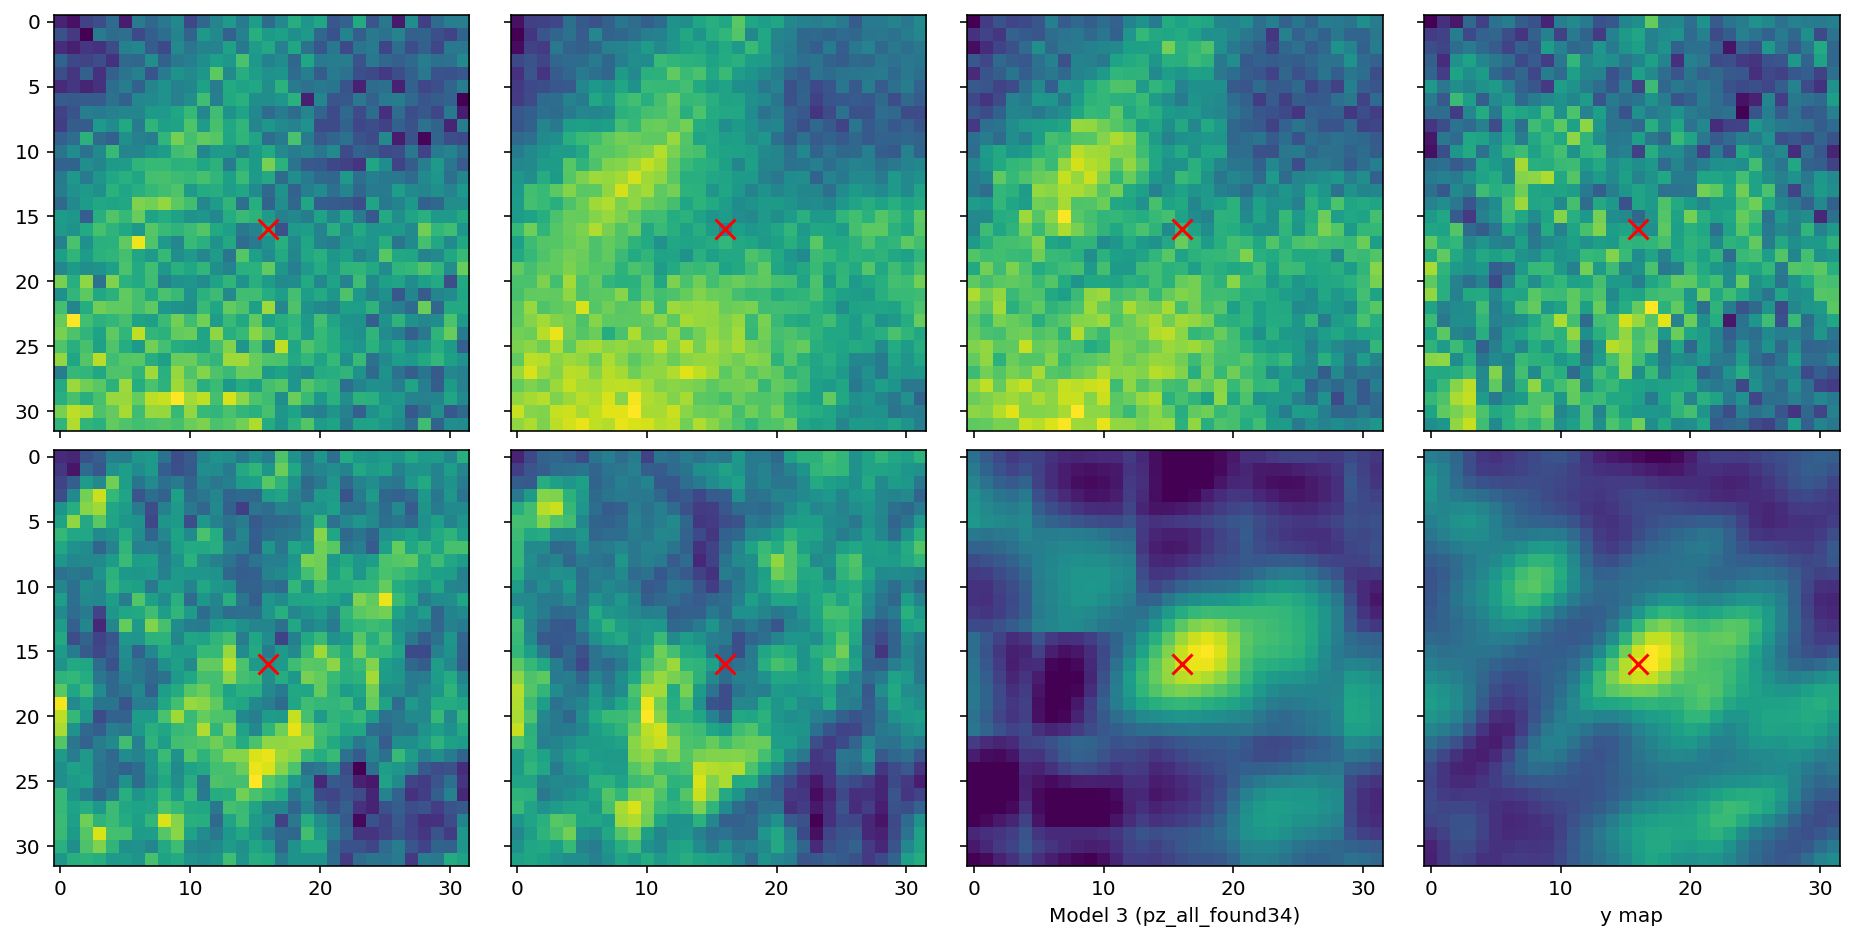

In [66]:
pic8(14)

RA           164.554
DEC         -2.20709
area              17
min_rad     0.645031
max_rad      3.26823
mean_rad     2.39619
min_pred    0.108511
max_pred    0.363592
tRA           164.57
tDEC        -2.19055
status            tp
catalog     planck_z
M500         4.98633
z           0.340297
pix2         val_pix
Name: 15, dtype: object
-2.229660749435425 1.7296148538589478
-1.9208720922470093 1.4620171785354614
-2.298776388168335 1.4067509174346924
-1.2425365447998047 3.250288248062134
1.5114102363586426 7.92690372467041
3.835639476776123 10.94771957397461
6.997781922812862e-07
-14.172501720507487 -0.30340832095822384
-0.5225400924682617 1.4963150024414062


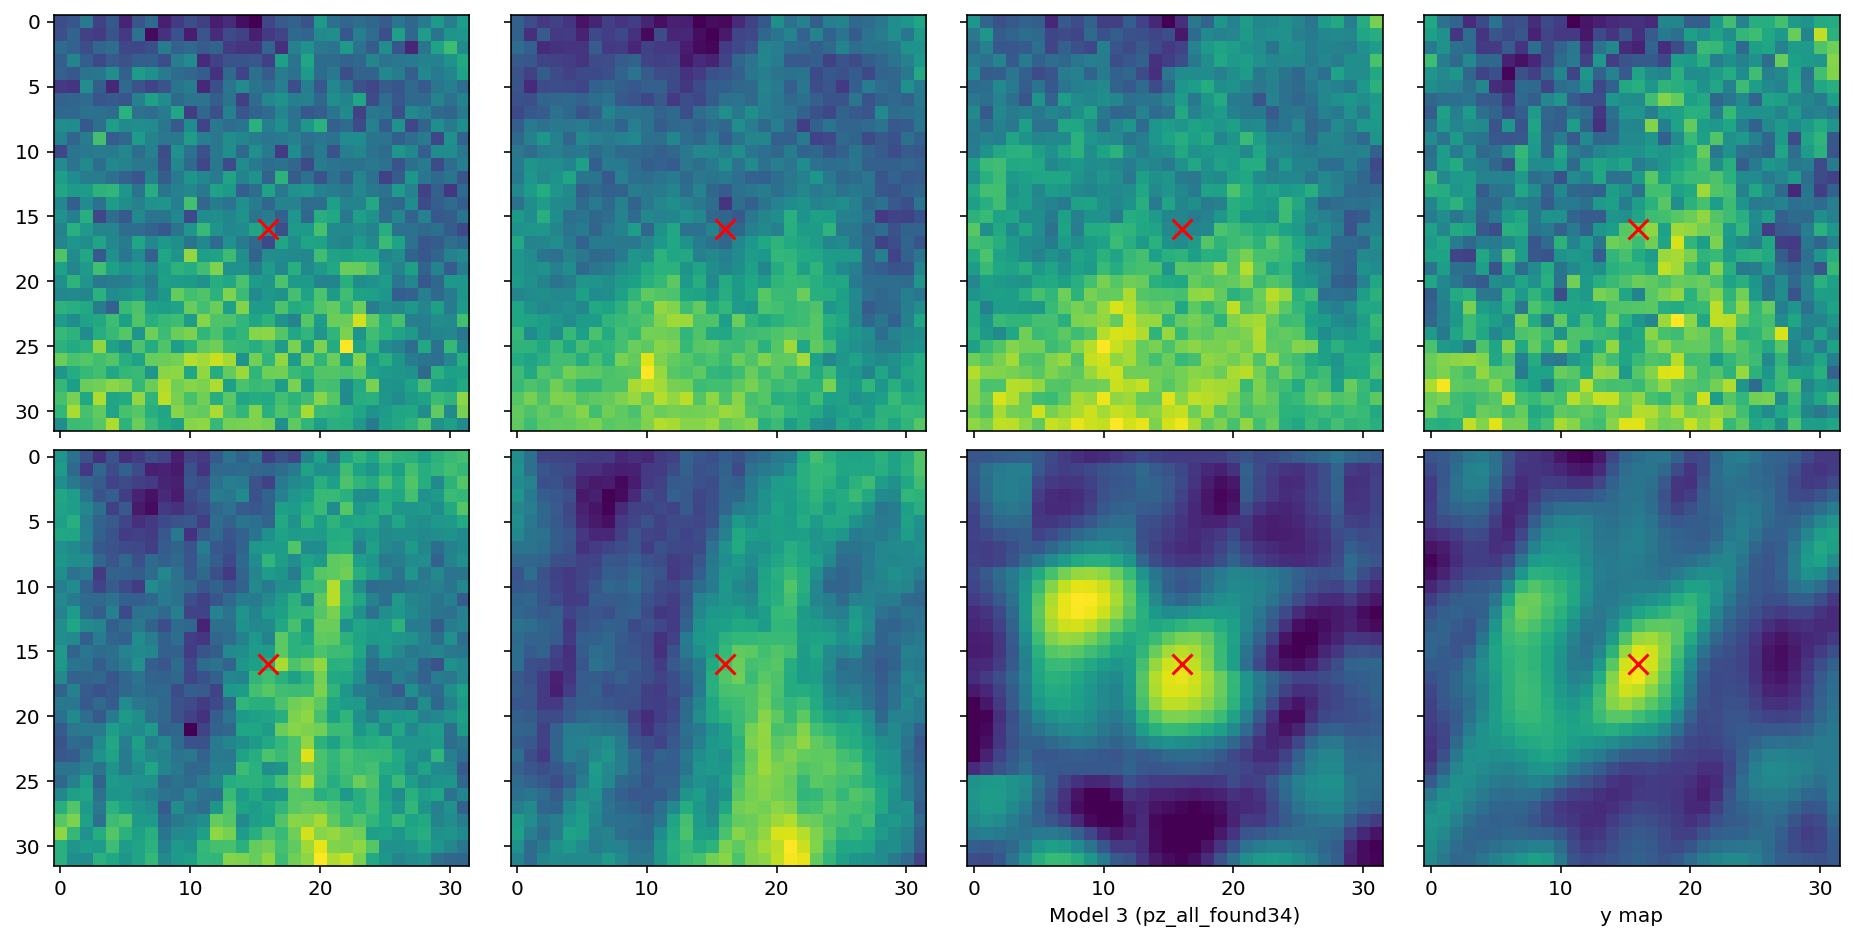

In [67]:
pic8(15)

RA           153.485
DEC        -0.964755
area              30
min_rad      2.04156
max_rad      4.36384
mean_rad     3.16847
min_pred    0.131641
max_pred    0.942517
tRA          153.505
tDEC       -0.958948
status            tp
catalog     planck_z
M500         1.70659
z             0.0445
pix2         val_pix
Name: 16, dtype: object


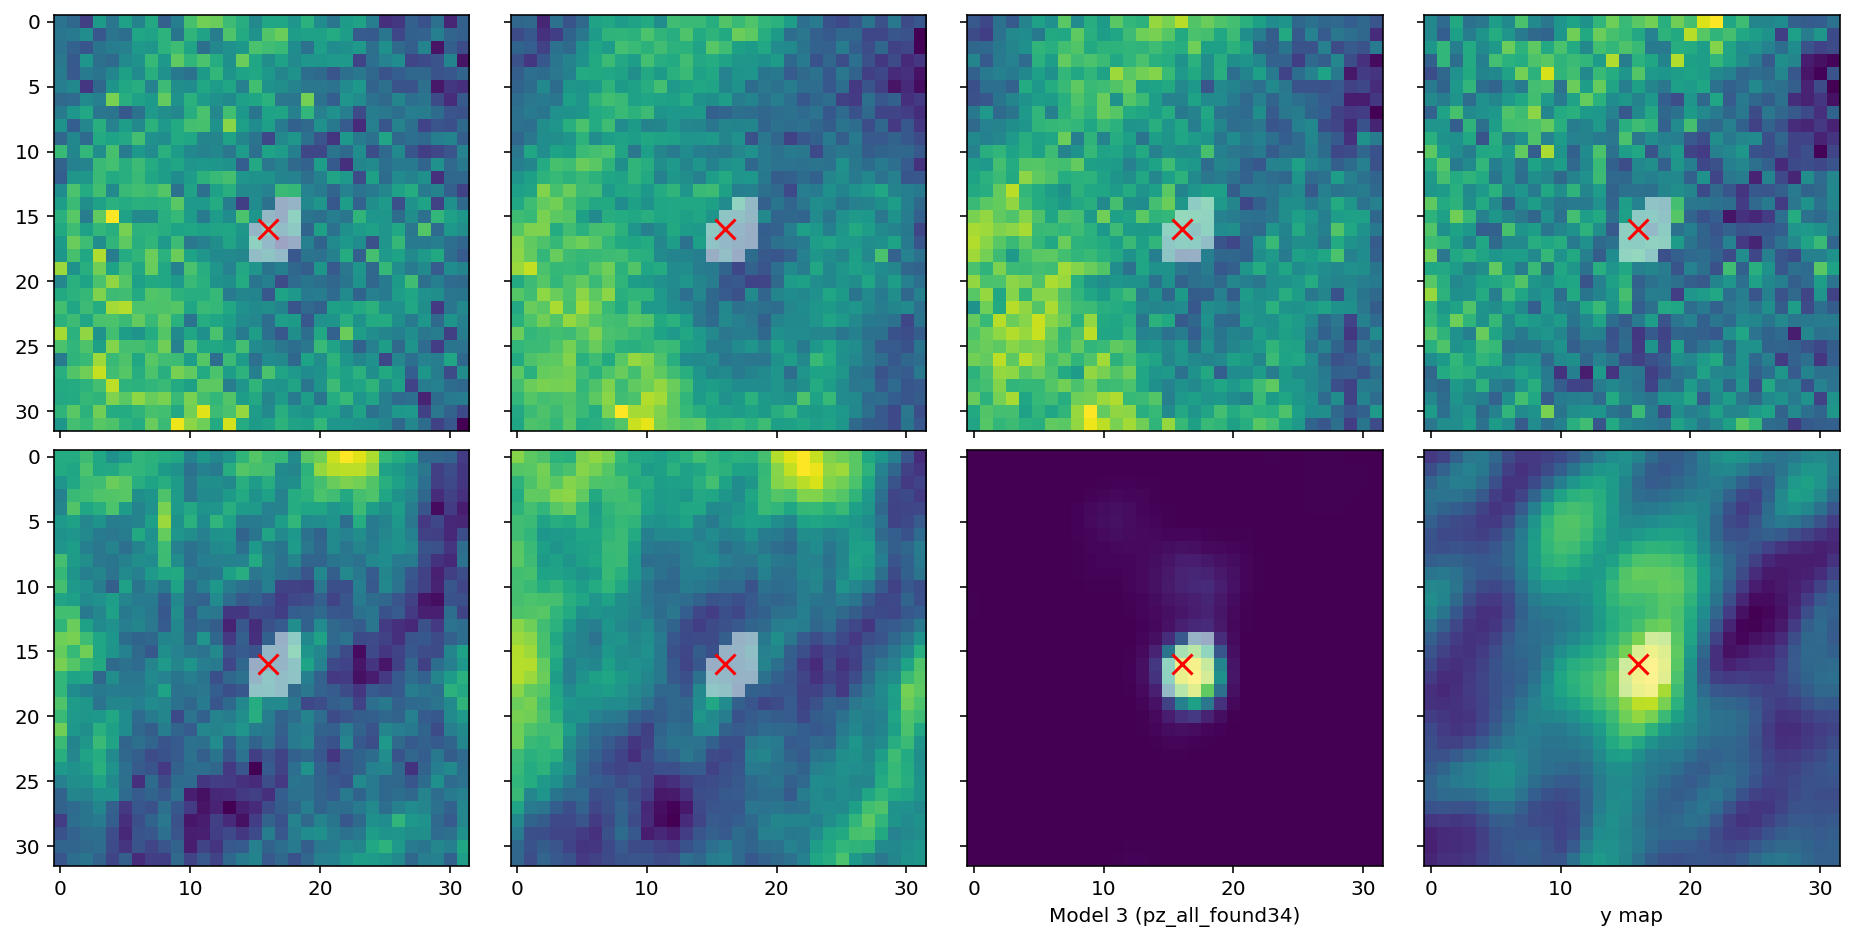

In [44]:
pic8(16)

In [45]:
cat.iloc[17]

RA           143.776
DEC         0.797716
area              30
min_rad       2.0899
max_rad      4.65023
mean_rad     3.21802
min_pred    0.140508
max_pred    0.928415
tRA           143.82
tDEC        0.818445
status            tp
catalog     planck_z
M500         5.47738
z           0.356823
pix2         val_pix
Name: 17, dtype: object

In [44]:
planck_z = pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv')
planck_z[np.abs(planck_z['RA'] - cat.iloc[17]['tRA']) < 0.1]

,Name,RA,DEC,z,M500,MCXC,RedMAPPer
724,PSZ2 G233.68+36.14,143.81963,0.818445,0.356823,5.47738,,RMJ093515.3+004746.0


In [2]:
radec2pix([143.82], [0.81], 2)

array([9])

In [34]:
cat

,RA,DEC,area,min_rad,max_rad,mean_rad,min_pred,max_pred,tRA,tDEC,status,catalog,M500,z,pix2
0,158.578513,-17.366779,26.0,1.538063,3.931250,2.926137,0.100574,0.991847,158.591452,-17.344174,tp,planck_z,3.761109,0.210000,val_pix
1,143.044506,-17.692850,25.0,1.508781,4.018180,2.868466,0.108636,0.996469,143.064934,-17.671431,tp,planck_z,6.647714,0.400000,val_pix
2,168.683142,-12.232978,28.0,1.364298,4.040432,3.046490,0.108908,0.993036,168.724666,-12.203231,tp,planck_z,4.211417,0.191200,val_pix
3,154.857399,-13.954883,28.0,1.901689,4.136645,3.077710,0.110801,0.991303,154.886857,-13.928393,tp,planck_z,4.091564,0.152752,val_pix
4,153.401558,-13.887999,26.0,1.803864,4.334789,3.006361,0.136148,0.682434,153.414024,-13.847364,tp,planck_z,3.183589,0.151700,val_pix
5,152.598812,-12.649150,26.0,1.829217,4.002192,2.958531,0.149865,0.949798,152.602786,-12.643998,tp,planck_z,4.942294,0.306200,val_pix
6,166.421870,-10.250464,24.0,1.330261,3.795929,2.851756,0.118800,0.970661,166.455731,-10.234796,tp,planck_z,6.084023,0.466000,val_pix
7,154.313689,-10.702125,32.0,1.649228,4.465583,3.275999,0.101968,0.979144,154.326616,-10.693876,tp,planck_z,2.303061,0.058600,val_pix
8,149.602390,-11.075071,32.0,1.800811,4.343814,3.260243,0.108370,0.992515,149.601781,-11.069007,tp,planck_z,5.406621,0.166900,val_pix
9,165.873539,-8.586564,31.0,1.793349,4.285102,3.210908,0.118154,0.926039,165.896683,-8.586460,tp,planck_z,3.321900,0.154000,val_pix
